### 1. Installing dependencies

In [ ]:
!pip install gymnasium gym-anytrading pandas matplotlib stable-baselines3[extra] finta

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 2. importing packages

In [ ]:
import gymnasium as gym
import gym_anytrading
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os


from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions

from stable_baselines3 import DQN
from stable_baselines3 import A2C
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback


from gym_anytrading.envs import StocksEnv
from finta import TA

### Constant

In [ ]:
WINDOW_SIZE = 25
AMOUNT_OF_EPISODES = 50
DATASET_PATH = '/content/processed_normalised_PAPER_TSLA_data.csv'


### 3. Read the dataset and preprocess it

In [ ]:
df = pd.read_csv(DATASET_PATH)

df['Date'] = pd.to_datetime(df.Date)

df.set_index('Date', inplace=True)

df.sort_index(inplace=True)

df.drop(columns='Unnamed: 0', inplace=True)

df['Day'] = df.index.dayofweek

### Calculate technical indicators using finta  

In [ ]:
df['SMA'] = TA.SMA(df, WINDOW_SIZE)
df['RSI'] = TA.RSI(df, WINDOW_SIZE)
df['MOM'] = TA.MOM(df, WINDOW_SIZE)
df['EMA'] = TA.EMA(df, WINDOW_SIZE)
df['AROONOSC'] = TA.AO(df,WINDOW_SIZE)
df.fillna(0, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Adj Close,Close,High,Low,Open,Volume,Sentiment,Day,SMA,RSI,MOM,EMA,AROONOSC
Date,,,,,,,,,,,,,
2014-01-02,-2.011301,-2.011301,-2.020447,-2.023991,-2.017095,-0.113856,0,3,0.0,0.000000,0.0,-2.011301,0.0
2014-01-03,-2.021067,-2.021067,-2.025626,-1.986322,-2.013475,-0.476426,0,4,0.0,0.000000,0.0,-2.016379,0.0
2014-01-06,-2.067366,-2.067366,-2.057597,-2.048062,-2.013475,-0.314709,0,0,0.0,0.000000,0.0,-2.034752,0.0
2014-01-07,-2.024684,-2.024684,-2.057597,-2.047879,-2.056558,-0.394099,0,1,0.0,44.400253,0.0,-2.031925,0.0
2014-01-08,-1.989960,-1.989960,-1.998657,-1.983382,-2.034292,-0.119974,0,2,0.0,59.601318,0.0,-2.022138,0.0


### Trading Environment

In [ ]:
class MyCustomEnv(StocksEnv):

  def __init__(self, df, window_size, frame_bound, **kwargs):
    super().__init__(df, window_size, frame_bound, **kwargs)

  def reset(self, seed=None, options=None):
    # super().reset(seed=seed, options=options)
    # self.action_space.seed(int((self.np_random.uniform(0, seed if seed is not None else 1))))

    self._truncated = False
    self._current_tick = self._start_tick
    self._last_trade_tick = self._current_tick - 1
    self._position = Positions.Short
    self._position_history = (self.window_size * [None]) + [self._position]
    self._total_reward = 0.
    self._total_profit = 1.  # unit
    self._first_rendering = True
    self.history = {}

    observation = self._get_observation()
    info = self._get_info()

    if self.render_mode == 'human':
        self._render_frame()

    return observation, info

  def _process_data (self):
    start = self.frame_bound[0] - self.window_size
    # print('env',env._position)
    end = self.frame_bound[1]
    prices = self.df.loc[:, 'Close'].to_numpy()[start:end]
    diff = np.insert(np.diff(prices), 0, 0)
    signal_features = self.df.loc[:, ['Close','Sentiment','SMA', 'RSI', 'MOM', 'EMA', 'AROONOSC']].to_numpy()[start:end]
    # Reshape diff to (282, 1)
    diff_reshaped = diff.reshape(len(diff), 1)

    # Concatenate along the second axis (columns)
    signal_features = np.concatenate((signal_features, diff_reshaped), axis=1)


    return prices, signal_features

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Dataset split

In [ ]:
train_df = df.loc[df.index < '2019-01-01']
test_df = df.loc[df.index >= '2019-01-01']

print('train_df: ',len(train_df))
print('test_df: ',len(test_df))

train_df:  1258
test_df:  252


In [ ]:
env = MyCustomEnv(df=train_df, frame_bound=(WINDOW_SIZE, len(train_df)), window_size=WINDOW_SIZE)

In [ ]:
env.signal_features[:1,:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[-2.01130062,  0.        ,  0.        ,  0.        ,  0.        ,
        -2.01130062,  0.        ,  0.        ]])

In [ ]:
env.action_space

Discrete(2)

Discrete: describes a discrete space where {0, 1, …, n-1} are the possible values our observation or action can take. Values can be shifted to {a, a+1, …, a+n-1} using an optional argument.

In [ ]:
env.action_space.sample()

1

Sell = 0

Buy = 1

In [ ]:
env.observation_space

Box(-10000000000.0, 10000000000.0, (25, 8), float32)

Box: describes an n-dimensional continuous space. It’s a bounded space where we can define the upper and lower limits which describe the valid values our observations can take.



In [ ]:
env.observation_space.sample()

array([[-1.16226970e+09, -7.79564032e+09,  5.07404442e+09,
        -1.01990221e+09,  2.94057626e+09, -7.09032141e+09,
         9.60583578e+09, -4.34004992e+09],
       [-1.43914022e+09, -1.56608666e+09, -7.99213696e+08,
         8.65627955e+09,  6.54555085e+09, -9.04741581e+09,
        -7.69613926e+09,  1.86903309e+09],
       [ 5.62134067e+09,  1.13801933e+09, -7.53128653e+09,
         6.03568333e+09,  5.68036096e+09, -7.97521562e+09,
         9.82317978e+09,  7.08960614e+09],
       [-7.81863578e+09,  7.58674330e+09, -9.09083648e+09,
         9.70480230e+09,  2.02309978e+09, -5.69196237e+09,
        -4.00564890e+09, -9.22037453e+09],
       [ 9.67719526e+09,  3.37378253e+09, -9.56621414e+09,
        -4.49086771e+09,  5.40983040e+08, -1.12733184e+09,
         6.29907302e+09,  7.42248499e+09],
       [-1.54309420e+07, -6.87668019e+09,  3.84107238e+09,
        -5.68020224e+09, -7.20723200e+09,  5.07301990e+09,
        -4.62976819e+09,  1.53970842e+09],
       [-2.03352304e+08, -9.371059

### 4. Create the environment and do some random action on it

info: {'total_reward': 3.1110752381384437, 'total_profit': 0.047170657323250056, 'position': <Positions.Long: 1>}


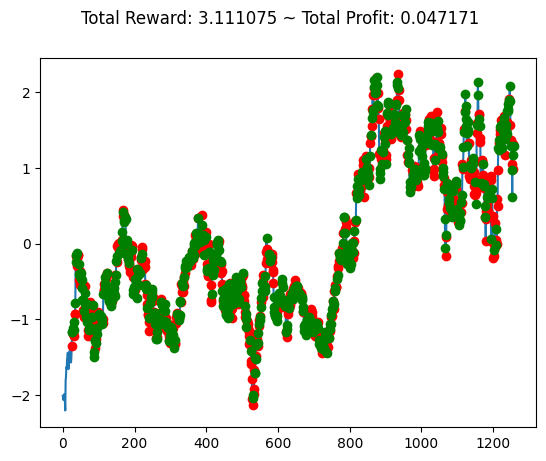

In [ ]:
observation = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.unwrapped.render_all()
plt.show()

### 5 creating and training the model

In [ ]:
model = A2C("MlpPolicy", env, verbose=1)

# Train the model
model.learn(total_timesteps=62900)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


------------------------------------
| time/                 |          |
|    fps                | 388      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.691   |
|    explained_variance | -0.00136 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.00499  |
|    value_loss         | 0.000225 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 402      |
|    iterations         | 200      |
|    time_elapsed       | 2        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.625   |
|    explained_variance | 4.89e-05 |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | 0.113    |
|    value_loss         | 0.0479   |
-

### Evaluate model

info: {'total_reward': 0.056245791697556724, 'total_profit': 0.8131415104887831, 'position': <Positions.Short: 0>}


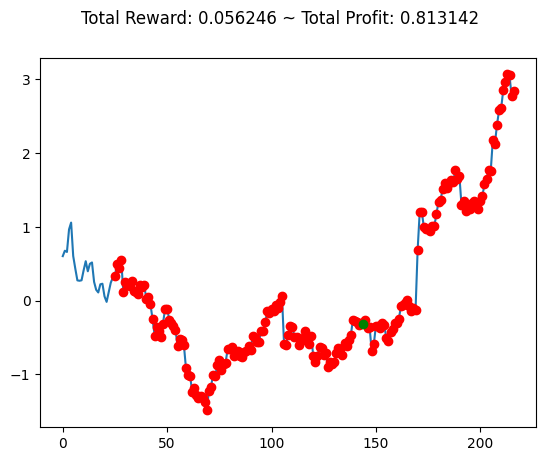

In [ ]:
env = MyCustomEnv(df=test_df, frame_bound=(60, len(test_df)), window_size=WINDOW_SIZE)

observation, info = env.reset()
while True:
    action = model.predict(observation)
    observation, reward, terminated, truncated, info = env.step(action[0])
    done = terminated or truncated

    if done:
        print("info:", info)
        # total_profit_list.append(info['total_profit'])
        # total_reward_list.append(info['total_reward'])
        break

plt.cla()
env.unwrapped.render_all()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


info: {'total_reward': 0.2405376620545275, 'total_profit': 2.050893924950446, 'position': <Positions.Short: 0>}


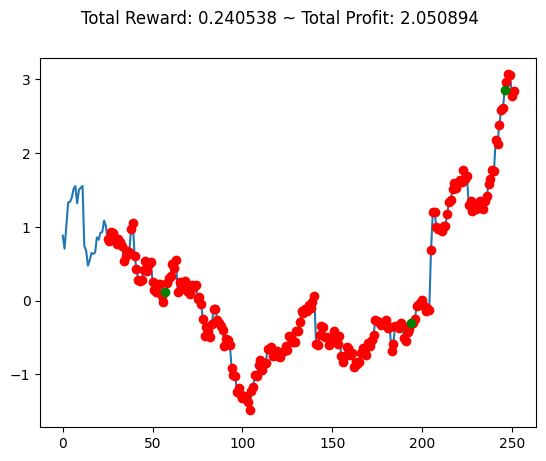

Sharpe Ratio: 5.193282303498196
Calmar Ratio: 2.040737677898793
info: {'total_reward': 0.2135901108713587, 'total_profit': -6.574896508569988, 'position': <Positions.Short: 0>}


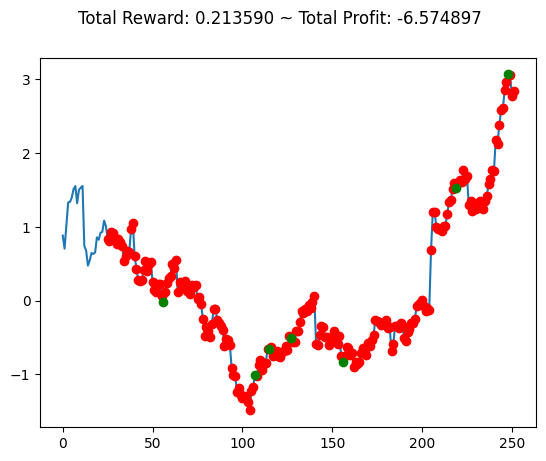

Sharpe Ratio: -2.1274303855483008
Calmar Ratio: -0.9084177695358981
info: {'total_reward': 0.3919131551706027, 'total_profit': 0.6300345554000032, 'position': <Positions.Short: 0>}


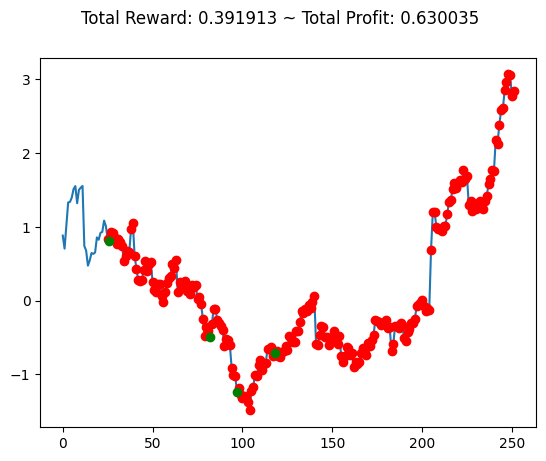

Sharpe Ratio: 3.537543664275991
Calmar Ratio: -0.826210922208939
info: {'total_reward': 0.20346320877012286, 'total_profit': 3.4517477705794404, 'position': <Positions.Short: 0>}


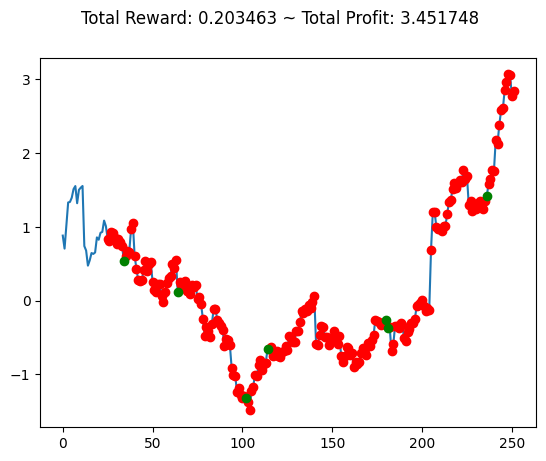

Sharpe Ratio: 3.3291371260973888
Calmar Ratio: 3.4517477705794404
info: {'total_reward': 0.49572431500848857, 'total_profit': 0.7127782184546985, 'position': <Positions.Short: 0>}


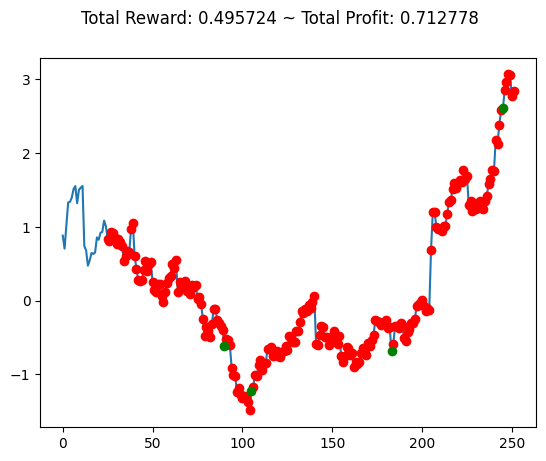

Sharpe Ratio: 6.248522159906225
Calmar Ratio: -0.8476084325991168


In [ ]:
total_profit_list = []
total_reward_list = []
total_sharpe_ratio_list = []
total_calmar_ratio_list = []

for i in range(5):

  env = MyCustomEnv(df=test_df, frame_bound=(WINDOW_SIZE, len(test_df)), window_size=WINDOW_SIZE)

  observation, info = env.reset(seed=2024)
  while True:
      action = model.predict(observation)
      observation, reward, terminated, truncated, info = env.step(action[0])
      done = terminated or truncated

      if done:
          print("info:", info)
          total_profit_list.append(info['total_profit'])
          total_reward_list.append(info['total_reward'])
          break

  plt.cla()
  env.unwrapped.render_all()
  plt.show()

  AWR = env.history['total_profit']

  average_sharpe_ratio = np.mean(AWR) / np.std(AWR)
  print('Sharpe Ratio:', average_sharpe_ratio)
  total_sharpe_ratio_list.append(average_sharpe_ratio)

  max_value = np.max(env.history['total_profit'])
  min_value = np.min(env.history['total_profit'])

  mdd = (max_value - min_value) / max_value


  ann_return = (info['total_profit'] - 1 ) / 1
  calmar_ratio = ann_return / mdd
  print('Calmar Ratio:', calmar_ratio)
  total_calmar_ratio_list.append(calmar_ratio)



In [ ]:
print('average sharpe ratio: ',np.mean(total_sharpe_ratio_list))
print('average calmar ratio: ',np.mean(total_calmar_ratio_list))
print('average profit: ',np.mean(total_profit_list))

average sharpe ratio:  3.2362109736459006
average calmar ratio:  0.5820496648268559
average profit:  0.054111592162920094


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
